In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df1 = pd.read_csv(r"C:\Users\Suwani Gunasekara\OneDrive\Documents\Sem 7 ML\Mid term\teamrank_GP_Poisson_1.csv")
df1.head()

,home_team,away_team,home_goals,away_goals,Ranking_home_team,Ranking_away_team,Total_Score_home_team,Total_Score_away_team,Total_count_home_team,Total_count_away_team,Year,tournament,HomeTeamRank_Difference,AwayTeamRank_Difference
0,Egypt,Czechoslovakia,2,0,21.0,18.0,45.0,47.0,0,0,1992,Friendly,3.0,-3.0
1,DR Congo,Ivory Coast,2,0,0.0,0.0,0.0,0.0,0,0,1992,Friendly,0.0,0.0
2,Guyana,Barbados,0,2,128.0,114.0,4.0,7.0,0,0,1992,Friendly,14.0,-14.0
3,Egypt,Norway,0,0,21.0,14.0,45.0,49.0,0,0,1992,Friendly,7.0,-7.0
4,Cameroon,Morocco,1,0,22.0,41.0,43.0,32.0,0,0,1992,African Cup of Nations,-19.0,19.0


In [3]:
# get the games played in 2000 and after
df_2000 = df1.loc[df1.Year>=2000].reset_index()

In [4]:
# split the dataset in to train and test
traindf2000, testdf2000 = train_test_split(df_2000, test_size=0.33, random_state=42)

In [5]:
goal_model_data_2000 = pd.concat([traindf2000[['home_team','away_team','home_goals','Total_Score_home_team',
                                       'Total_count_home_team','HomeTeamRank_Difference','tournament']].assign(home=1).rename(
            columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals',
                     'Total_Score_home_team':'total_score','Total_count_home_team':'total_count','HomeTeamRank_Difference':'rank_difference','tournament':'tournament'}),
           traindf2000[['away_team','home_team','away_goals','Total_Score_away_team','Total_count_away_team',
                     'AwayTeamRank_Difference']].assign(home=0).rename(
            columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals',
                    'Total_Score_away_team':'total_score','Total_count_away_team':'total_count',
                     'AwayTeamRank_Difference':'rank_difference','tournament':'tournament'})])

In [6]:
goal_model_data_2000.head()

,team,opponent,goals,total_score,total_count,rank_difference,tournament,home
4029,Solomon Islands,Tonga,6,320.916667,2,-43.583333,FIFA World Cup qualification,1
5981,Seychelles,Mauritius,2,149.272727,1,13.909091,Friendly,1
9300,Estonia,Albania,0,291.083333,10,22.250000,Friendly,1
10510,Tahiti,New Caledonia,1,55.416667,0,23.666667,Friendly,1
2206,American Samoa,Papua New Guinea,0,18.545455,2,20.636364,Oceania Nations Cup qualification,1


In [7]:
poisson_model_2000= smf.glm(formula="goals ~ rank_difference", data=goal_model_data_2000, 
                        family=sm.families.Poisson()).fit()
poisson_model_2000.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                26288
Model:                            GLM   Df Residuals:                    26286
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41974.
Date:                Mon, 16 Aug 2021   Deviance:                       39980.
Time:                        11:31:04   Pearson chi2:                 4.53e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2755      0.005     50.140      0.000       0.265       0.286
rank_difference    -0.0049   7.99e-05    -61.714      0.000      -0.005      -0.005
===================================================================================
"""

In [8]:
def getPrediction(model,ht_rd,at_rd):
    predictdict = {}
    home_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': ht_rd},index = [1])).values[0])
    away_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': at_rd},index = [1])).values[0])

    if home_team_goals > away_team_goals:
        predictdict['pred'] = "HW"
    elif home_team_goals < away_team_goals:
        predictdict['pred'] = "AW"
    else:
        predictdict['pred'] = "D"
    return predictdict

In [10]:
wl_ = []
for index,row in testdf2000.iterrows():
    alldictpredict = {}
    
    home_team = row['home_team']
    away_team = row['away_team']
    ht_rd     = row['HomeTeamRank_Difference']
    at_rd     = row['AwayTeamRank_Difference']
    pred = getPrediction(poisson_model_2000,ht_rd,at_rd)
    
    
    alldictpredict['home_team'] = row['home_team']
    alldictpredict['away_team'] = row['away_team']
    #alldict['Goals'] = row['WonGoals']
    alldictpredict['pred'] = pred['pred']
    if row['home_goals']>row['away_goals']:
        alldictpredict['actual'] = "HW"
    elif row['home_goals']<row['away_goals']:
        alldictpredict['actual'] = "AW"
    else:
        alldictpredict['actual'] = "D"
    #alldictpredict['home_goals'] = row['home_goals']
    #alldictpredict['away_goals'] = row['away_goals']
    #print(alldict)
    wl_.append(alldictpredict)
    df_p_2000 = pd.DataFrame(wl_)
    
    #print(year,month,home_team,away_team) 

In [13]:
y_test = df_p_2000.actual
y_pred = df_p_2000.pred
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 865,  713,  218],
       [ 447,  754,  343],
       [ 431, 1169, 1534]], dtype=int64)

In [14]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion = df_confusion.drop(['All'], axis = 1)
df_confusion = df_confusion.drop(['All'], axis = 0)
df_confusion.head()

Predicted,AW,D,HW
Actual,,,
AW,865,713,218
D,447,754,343
HW,431,1169,1534


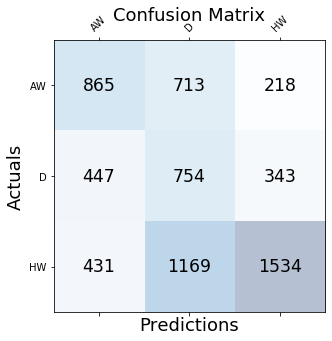

In [15]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [16]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['AW', 'D', 'HW']))


Accuracy: 0.49

Micro Precision: 0.49
Micro Recall: 0.49
Micro F1-score: 0.49

Macro Precision: 0.50
Macro Recall: 0.49
Macro F1-score: 0.48

Weighted Precision: 0.56
Weighted Recall: 0.49
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

          AW       0.50      0.48      0.49      1796
           D       0.29      0.49      0.36      1544
          HW       0.73      0.49      0.59      3134

    accuracy                           0.49      6474
   macro avg       0.50      0.49      0.48      6474
weighted avg       0.56      0.49      0.51      6474



In [17]:
poisson_model_2000_2= smf.glm(formula="goals ~ rank_difference+total_score", data=goal_model_data_2000, 
                        family=sm.families.Poisson()).fit()
poisson_model_2000_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                26288
Model:                            GLM   Df Residuals:                    26285
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41928.
Date:                Mon, 16 Aug 2021   Deviance:                       39888.
Time:                        11:37:29   Pearson chi2:                 4.59e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2104      0.009     23.902      0.000       0.193       0.228
rank_difference    -0.0049   8.06e-05    -61.095      0.000      -0.005      -0.005
total_score         0.0001   1.26e-05      9.645      0.000    9.67e-05       0.000
===================================================================================
"""

In [20]:
def getPrediction(model,ht_rd,at_rd,ts_ht,ts_at):
    predictdict = {}
    home_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': ht_rd,'total_score':ts_ht},index = [1])).values[0])
    away_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': at_rd,'total_score':ts_at},index = [1])).values[0])

    if home_team_goals > away_team_goals:
        predictdict['pred'] = "HW"
    elif home_team_goals < away_team_goals:
        predictdict['pred'] = "AW"
    else:
        predictdict['pred'] = "D"
    return predictdict


wl_ = []
for index,row in testdf2000.iterrows():
    alldictpredict = {}
    
    home_team = row['home_team']
    away_team = row['away_team']
    ht_rd     = row['HomeTeamRank_Difference']
    at_rd     = row['AwayTeamRank_Difference']
    ts_ht     = row['Total_Score_home_team']
    ts_at     = row['Total_Score_away_team']
    pred = getPrediction(poisson_model_2000_2,ht_rd,at_rd,ts_ht,ts_at)
    
    
    alldictpredict['home_team'] = row['home_team']
    alldictpredict['away_team'] = row['away_team']
    #alldict['Goals'] = row['WonGoals']
    alldictpredict['pred'] = pred['pred']
    if row['home_goals']>row['away_goals']:
        alldictpredict['actual'] = "HW"
    elif row['home_goals']<row['away_goals']:
        alldictpredict['actual'] = "AW"
    else:
        alldictpredict['actual'] = "D"
    #alldictpredict['home_goals'] = row['home_goals']
    #alldictpredict['away_goals'] = row['away_goals']
    #print(alldict)
    wl_.append(alldictpredict)
    df_p_2000_2 = pd.DataFrame(wl_)
    
    #print(year,month,home_team,away_team) 

In [21]:
y_test = df_p_2000_2.actual
y_pred = df_p_2000_2.pred
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 927,  627,  242],
       [ 484,  683,  377],
       [ 465, 1038, 1631]], dtype=int64)

In [22]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion = df_confusion.drop(['All'], axis = 1)
df_confusion = df_confusion.drop(['All'], axis = 0)
df_confusion.head()

Predicted,AW,D,HW
Actual,,,
AW,927,627,242
D,484,683,377
HW,465,1038,1631


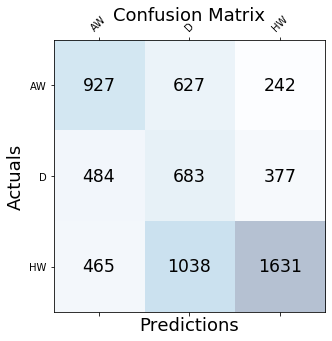

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [24]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['AW', 'D', 'HW']))


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.50
Macro Recall: 0.49
Macro F1-score: 0.49

Weighted Precision: 0.56
Weighted Recall: 0.50
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

          AW       0.49      0.52      0.50      1796
           D       0.29      0.44      0.35      1544
          HW       0.72      0.52      0.61      3134

    accuracy                           0.50      6474
   macro avg       0.50      0.49      0.49      6474
weighted avg       0.56      0.50      0.52      6474



In [25]:
poisson_model_2000_3= smf.glm(formula="goals ~ rank_difference+total_score+total_count", data=goal_model_data_2000, 
                        family=sm.families.Poisson()).fit()
poisson_model_2000_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                26288
Model:                            GLM   Df Residuals:                    26284
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -41925.
Date:                Mon, 16 Aug 2021   Deviance:                       39884.
Time:                        11:45:17   Pearson chi2:                 4.58e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2257      0.011     20.067      0.000       0.204       0.248
rank_difference    -0.0049   8.05e-05    -61.210      0.000      -0.005      -0.005
total_score         0.0001    1.3e-05      9.897      0.000       0.000       0.000
total_count        -0.0038      0.002     -2.181      0.029      -0.007      -0.000
===================================================================================
"""

In [26]:
def getPrediction(model,ht_rd,at_rd,ts_ht,ts_at,ht_tc,at_tc):
    predictdict = {}
    home_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': ht_rd,'total_score':ts_ht,'total_count':ht_tc},index = [1])).values[0])
    away_team_goals = round(model.predict(pd.DataFrame(data = {'rank_difference': at_rd,'total_score':ts_at,'total_count':at_tc},index = [1])).values[0])

    if home_team_goals > away_team_goals:
        predictdict['pred'] = "HW"
    elif home_team_goals < away_team_goals:
        predictdict['pred'] = "AW"
    else:
        predictdict['pred'] = "D"
    return predictdict


wl_ = []
for index,row in testdf2000.iterrows():
    alldictpredict = {}
    
    home_team = row['home_team']
    away_team = row['away_team']
    ht_rd     = row['HomeTeamRank_Difference']
    at_rd     = row['AwayTeamRank_Difference']
    ts_ht     = row['Total_Score_home_team']
    ts_at     = row['Total_Score_away_team']
    ht_tc     = row['Total_count_home_team']     
    at_tc     = row['Total_count_away_team']
    pred = getPrediction(poisson_model_2000_3,ht_rd,at_rd,ts_ht,ts_at,ht_tc,at_tc)
    
    
    alldictpredict['home_team'] = row['home_team']
    alldictpredict['away_team'] = row['away_team']
    #alldict['Goals'] = row['WonGoals']
    alldictpredict['pred'] = pred['pred']
    if row['home_goals']>row['away_goals']:
        alldictpredict['actual'] = "HW"
    elif row['home_goals']<row['away_goals']:
        alldictpredict['actual'] = "AW"
    else:
        alldictpredict['actual'] = "D"
    #alldictpredict['home_goals'] = row['home_goals']
    #alldictpredict['away_goals'] = row['away_goals']
    #print(alldict)
    wl_.append(alldictpredict)
    df_p_2000_3 = pd.DataFrame(wl_)
    
    #print(year,month,home_team,away_team) 

In [27]:
y_test = df_p_2000_3.actual
y_pred = df_p_2000_3.pred
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 918,  639,  239],
       [ 483,  684,  377],
       [ 468, 1053, 1613]], dtype=int64)

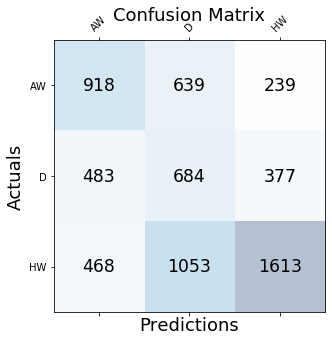

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
tick_marks = np.arange(len(df_confusion.columns))
plt.xticks(tick_marks, df_confusion.columns, rotation=45)
plt.yticks(tick_marks, df_confusion.index)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [29]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['AW', 'D', 'HW']))


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.50
Macro Recall: 0.49
Macro F1-score: 0.48

Weighted Precision: 0.56
Weighted Recall: 0.50
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

          AW       0.49      0.51      0.50      1796
           D       0.29      0.44      0.35      1544
          HW       0.72      0.51      0.60      3134

    accuracy                           0.50      6474
   macro avg       0.50      0.49      0.48      6474
weighted avg       0.56      0.50      0.51      6474

